In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *

In [2]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1.5
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3, 2.5, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 6, 1, obs_act, 'Obs3')
obs4 = Obstacle(4, 4, 1, obs_act, 'Obs4')
obs5 = Obstacle(6, 7.5, 1, obs_act, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [3]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 1000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 500, 0, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [4]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
xs_optimal = XS_Set_optimal[0]
us_optimal = US_Set_optimal[0]
# xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

10 Trajectories Collected
20 Trajectories Collected
Trajectory 23 Rejected
30 Trajectories Collected
Trajectory 33 Rejected
Trajectory 34 Rejected
40 Trajectories Collected
Trajectory 46 Rejected
Trajectory 47 Rejected
50 Trajectories Collected
60 Trajectories Collected
70 Trajectories Collected
Trajectory 77 Rejected
Trajectory 78 Rejected
80 Trajectories Collected
Trajectory 87 Rejected
90 Trajectories Collected
100 Trajectories Collected


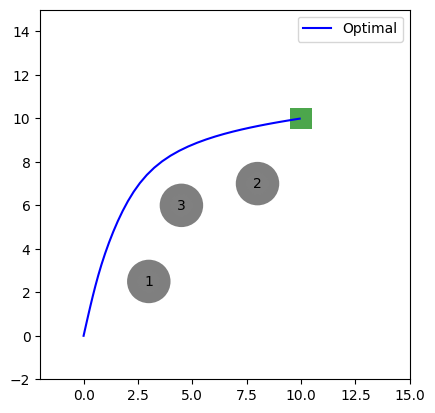

In [5]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [6]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [7]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [23]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, use_factor = False, Lambda = 0.001):
    opt_traj_feat = cost_set.cum_feat(xs_optimal, us_optimal, dt)
    bad_traj_feat = cost_set.cum_feat(np.zeros_like(xs_optimal), np.zeros_like(us_optimal), dt)
    factor = 1
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        if use_factor:
            non_opt_traj_feat = cost_set.cum_feat(Xs, Us, dt)
            o = np.exp(np.linalg.norm(opt_traj_feat - non_opt_traj_feat)/(np.linalg.norm(opt_traj_feat - bad_traj_feat)))
            den += np.max([np.nextafter(0,1),o*np.exp(-non_opt_traj_cost)])
        else:
            den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    # output += Lambda*np.linalg.norm(x - w_old)
    return output

def fcn_w_2D(x, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    den += np.exp(-cost_set.traj_cost(xs_non_optimal, us_non_optimal, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [24]:
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
use_factor = True

w0 = w_bad
w_prev = w0
it = 0
max_set_size = 5
# it_max_IRL = max_set_size + 1
it_max_IRL = 50
it_max_sqp = 5

xs = []
us = []
ws = []
Fcns= []
Cost_Diffs = []
W_Diffs = []
Traj_Diffs = []
Opt_Vals = []

xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)

init_choices = ['bad','optimal','previous']
stochastic = False
w_tol = 0.00001
traj_tol = 1e-10
w_diff = 1
traj_diff = 1
e = 1
opt_feat = cost_set.cum_feat(xs_optimal,us_optimal,dt)
non_opt_feat = cost_set.cum_feat(xs_non_optimal, us_non_optimal, dt)
while traj_diff > traj_tol and it < it_max_IRL:
    
    sqp_non_opt = reset_weights(sqp_non_opt, w0[:nr], w0[nr:])
    
    # With simple regulation: ||w||
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, use_factor, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    # # With simple new regulation: ||w - w_old||
    # res = minimize(fcn_w_new, 
    #                w0, 
    #                args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, w_prev, Lambda), 
    #                bounds=bnds, 
    #                method='L-BFGS-B', 
    #                tol = tol,
    #                options=options)
    
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)
    fcn_value = fcn_w(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)
    # fcn_value = 0.0
    Fcns.append(fcn_value)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]

    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy()))
    ws.append(w_loop.copy())
    traj_feat = cost_set.cum_feat(sqp_non_opt.xs.tolist().copy(), sqp_non_opt.us.tolist().copy(), dt)
    # traj_optimality = np.exp(-(np.linalg.norm(opt_feat-traj_feat)))
    # traj_nonoptimality = (np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat))
    optimality = np.exp((np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)))
    Opt_Vals.append(optimality)
    
    if len(xs) <= max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if not stochastic:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
        else:
            xs_non_optimal_set = random.choices(xs, k=max_set_size)
            us_non_optimal_set = random.choices(us, k=max_set_size)
        
    
    opt_diff = (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], dt)- cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], dt))**2 
                
    w_diff = np.linalg.norm(w_loop - w_prev)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2
    Cost_Diffs.append(opt_diff)
    W_Diffs.append(w_diff)
    Traj_Diffs.append(traj_diff)
    if it > 0:
        print('Fcn Value: {:.4f} || Weight Diff: {:.4f} || Traj Diff: {:.4f}, || Optimality: {:.4f}'.format(
            fcn_value, w_diff, traj_diff, optimality
        ))
    
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()
    
    w_prev = w0
    it += 1
    # if it == it_max_IRL-1:
    #     # options['maxiter'] = 200
    #     xs_non_optimal_set = xs
    #     us_non_optimal_set = us

print(res)
w_irl = res.x/np.max(res.x)
# w_irl = ws[ws.index(min(ws))+1]

Fcn Value: 0.0012 || Weight Diff: 0.3091 || Traj Diff: 13496.1659, || Optimality: 142.7421
Fcn Value: 0.0012 || Weight Diff: 0.0000 || Traj Diff: 6019.3940, || Optimality: 2.1124
Fcn Value: 0.0707 || Weight Diff: 0.6585 || Traj Diff: 7838.2114, || Optimality: 2.1124
Fcn Value: 0.0020 || Weight Diff: 0.0434 || Traj Diff: 35.7643, || Optimality: 1.6587
Fcn Value: 0.6554 || Weight Diff: 0.3190 || Traj Diff: 1.2714, || Optimality: 1.5779
Fcn Value: 1.1471 || Weight Diff: 0.0002 || Traj Diff: 0.0627, || Optimality: 1.4512
Fcn Value: 0.9776 || Weight Diff: 0.7542 || Traj Diff: 1.5207, || Optimality: 1.4546
Fcn Value: 1.2238 || Weight Diff: 0.8026 || Traj Diff: 0.0003, || Optimality: 3.7229
Fcn Value: 1.4656 || Weight Diff: 0.0027 || Traj Diff: 0.8792, || Optimality: 3.7229
Fcn Value: 1.6037 || Weight Diff: 0.0013 || Traj Diff: 0.0353, || Optimality: 1.4491
Fcn Value: 1.7442 || Weight Diff: 0.0167 || Traj Diff: 4.6691, || Optimality: 1.3412
Fcn Value: 3.8006 || Weight Diff: 0.1074 || Traj Dif

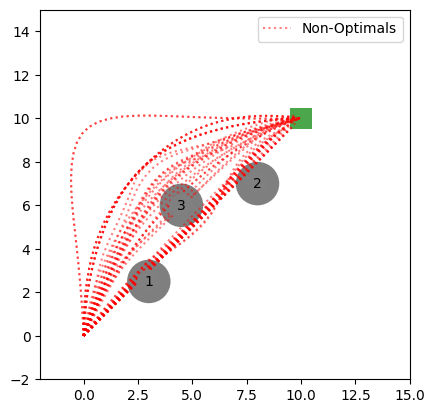

In [29]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

1.0472456862105142


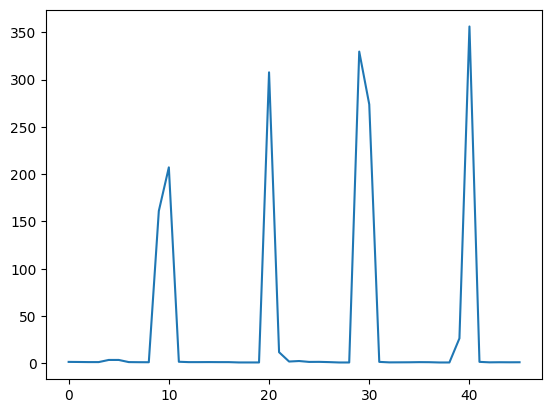

In [30]:
n = Opt_Vals.index(min(Opt_Vals))
plt.plot(Opt_Vals[4:])
print(min(Opt_Vals))

In [31]:
# w_irl = ws[n+1]
w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.019378649049103865
Terminal ||  Desired:  1.0 IRL:  0.9868764245262288

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.003240113059616115
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  1.0 IRL:  0.9167213733926353
Terminal ||  Desired:  0.5 IRL:  0.0

Obs2 :
Running ||  Desired:  1.0 IRL:  0.7750701561032184
Terminal ||  Desired:  0.5 IRL:  0.019693086401317287

Obs3 :
Running ||  Desired:  1.0 IRL:  1.0
Terminal ||  Desired:  0.5 IRL:  0.0



In [32]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

Desired:                  3.170074066067171
IRL:                      3.2785994854850813

Desired Trajectory Cost:  0.9871325704160181
with IRL Weight:          3.688043496692866

IRL Trajectory Cost:      3.555802377582463
with Desired Weight:      1.2211394743134278


In [33]:
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)

10 Trajectories Collected
20 Trajectories Collected
Trajectory 23 Rejected
30 Trajectories Collected
Trajectory 33 Rejected
Trajectory 34 Rejected
40 Trajectories Collected
Trajectory 46 Rejected
Trajectory 47 Rejected
50 Trajectories Collected
60 Trajectories Collected
70 Trajectories Collected
Trajectory 77 Rejected
Trajectory 78 Rejected
80 Trajectories Collected
Trajectory 87 Rejected
90 Trajectories Collected
100 Trajectories Collected


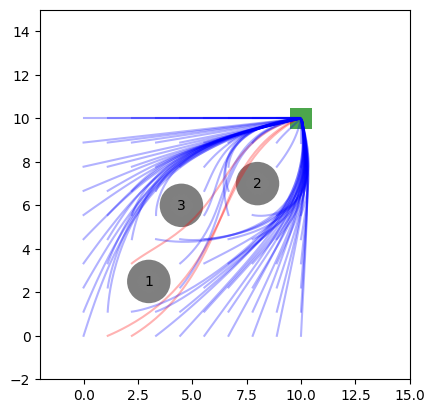

3


In [34]:
print(plot_tested_model(XS_Set, obs_set, target_high))
# print(plot_tested_model(XS_Set_optimal, obs_set, target_high))

In [ ]:
HTML(animateTraj(xs_optimal, xs, obs_set, target_high, sleep=500, animType=2).to_jshtml())

In [17]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  2.55757e+02  2.55757e+02  3.82024e+01  1.0000  0.00000e+00  4.57984e+00
   2  1.02677e+02  1.02677e+02  1.47040e+00  1.0000  1.53211e-14  1.40537e-01
   3  1.02576e+02  1.02576e+02  5.22721e-02  1.0000  2.68347e-09  5.50132e-03
 END  1.02576e+02  1.02576e+02  7.70324e-05   ----   8.76128e-11  9.30511e-06


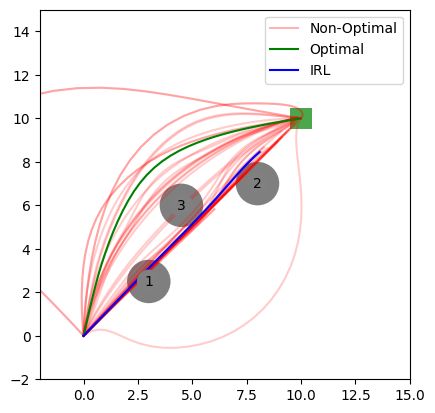

In [18]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [19]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs, us):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [20]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

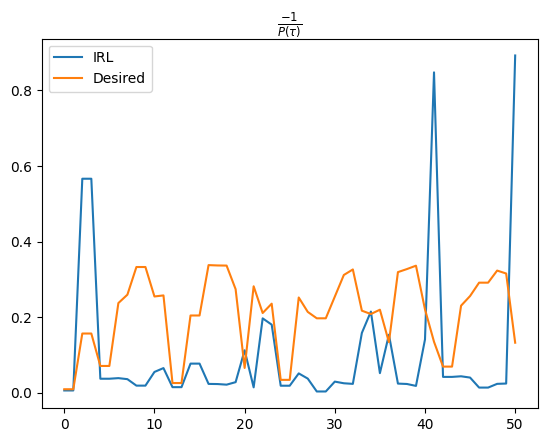

In [21]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()

In [22]:
# # Add a noisy trajectory to the set
# # scale = 1/traj_diff + 1.0
# scale = 5.0
# noisy_u = np.vstack(sqp_non_opt.us.tolist().copy())+np.random.normal(0.0,scale,np.stack(sqp_non_opt.us.tolist()).shape)
# us.append(noisy_u)
# xs.append(np.stack(problem.rollout([noisy_u[i] for i in range(T)])))